# DuckDB in Jupyter Notebooks
A streamlined workflow for SQL analysis with DuckDB and Jupyter

## STEP 1 Library Import and Configuration

In [1]:
!pip install --quiet duckdb
!pip install --quiet jupysql
!pip install --quiet duckdb-engine
!pip install --quiet pandas
!pip install --quiet matplotlib

You should consider upgrading via the 'e:\notebook\notebook_env\scripts\python.exe -m pip install --upgrade pip' command.
You should consider upgrading via the 'e:\notebook\notebook_env\scripts\python.exe -m pip install --upgrade pip' command.
You should consider upgrading via the 'e:\notebook\notebook_env\scripts\python.exe -m pip install --upgrade pip' command.
You should consider upgrading via the 'e:\notebook\notebook_env\scripts\python.exe -m pip install --upgrade pip' command.
You should consider upgrading via the 'e:\notebook\notebook_env\scripts\python.exe -m pip install --upgrade pip' command.


In [2]:
import duckdb
import pandas as pd
# No need to import sqlalchemy or duckdb_engine
#  JupySQL will use SQLAlchemy to auto-detect the driver needed based on your connection string!

# Import jupysql Jupyter extension to create SQL cells
%load_ext sql

We configure jupysql to return data as a Pandas dataframe and have less verbose output

In [3]:
%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False

## Connecting to DuckDB
Connect jupysql to DuckDB using a SQLAlchemy-style connection string. You may either connect to an in memory DuckDB, or a file backed db.

In [4]:
%sql duckdb:///:memory:
# %sql duckdb:///path/to/file.db

## Step 2 Querying DuckDB
Single line SQL queries can be run using `%sql` at the start of a line. Query results will be displayed as a Pandas DF. Note the SQL syntax highlighting!

In [5]:
%sql SELECT 'Off and flying!' as a_duckdb_column

,a_duckdb_column
0,Off and flying!


An entire Jupyter cell can be used as a SQL cell by placing `%%sql` at the start of the cell. Query results will be displayed as a Pandas DF.

In [6]:
%%sql
SELECT
    schema_name,
    function_name
FROM duckdb_functions()
ORDER BY ALL DESC
LIMIT 5

,schema_name,function_name
0,pg_catalog,shobj_description
1,pg_catalog,shobj_description
2,pg_catalog,shobj_description
3,pg_catalog,pg_typeof
4,pg_catalog,pg_typeof


To return query results into a Pandas dataframe for future usage, use `<<` as an assignment operator. This can be used with both the `%sql` and `%%sql` Jupyter magics.

In [7]:
%sql my_df << SELECT 'Off and flying!' as a_duckdb_column
my_df

,a_duckdb_column
0,Off and flying!


## Querying Pandas Dataframes
DuckDB is able to find and query any dataframe stored as a variable in the Jupyter notebook.

In [8]:
input_df = pd.DataFrame.from_dict({"i":[1, 2, 3],
                                  "j":["one", "two", "three"]})

The dataframe being queried can be specified just like any other table in the `FROM` clause.

In [9]:
%sql output_df << SELECT sum(i) as total_i FROM input_df
output_df # Sql output saved in Pandas dataframe

,total_i
0,6.0


## Visualizing DuckDB Data
The most common way to plot datasets in Python is to load them using pandas and then use matplotlib or seaborn for plotting.
This approach requires loading all data into memory which is highly inefficient.
The plotting module in JupySQL runs computations in the SQL engine.
This delegates memory management to the engine and ensures that intermediate computations do not keep eating up memory, efficiently plotting massive datasets.

### Install and Load DuckDB httpfs extension
DuckDB's [httpfs extension](https://duckdb.org/docs/extensions/httpfs) allows parquet and csv files to be queried remotely over http.
These examples query a parquet file that contains historical taxi data from NYC.
Using the parquet format allows DuckDB to only pull the rows and columns into memory that are needed rather than download the entire file.
DuckDB can be used to process [local parquet files as well](https://duckdb.org/docs/data/parquet), which may be desirable if querying the entire parquet file, or running multiple queries that require large subsets of the file.


In [10]:
%%sql
INSTALL httpfs;
LOAD httpfs;

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,Success


### Boxplot & Histogram
To create a boxplot, call `%sqlplot boxplot`, passing the name of the table and the column to plot.
In this case, the name of the table is the URL of the remotely stored parquet file.

(duckdb.duckdb.CatalogException) Catalog Error: Table with name cloudfront does not exist!
Did you mean "information_schema.columns"?
LINE 6:     FROM "https://d37ci6vzurychx"."cloudfront"
                 ^
[SQL: 
    SELECT
    percentile_disc([0.25, 0.50, 0.75]) WITHIN GROUP     (ORDER BY "trip_distance") AS percentiles,
    AVG("trip_distance") AS mean,
    COUNT(*) AS N
    FROM "https://d37ci6vzurychx"."cloudfront"]
(Background on this error at: https://sqlalche.me/e/20/f405)


RuntimeError: 
Ensure that percentile_disc function is available on duckdb_engine.
If you need help solving this issue, send us a message: https://ploomber.io/community


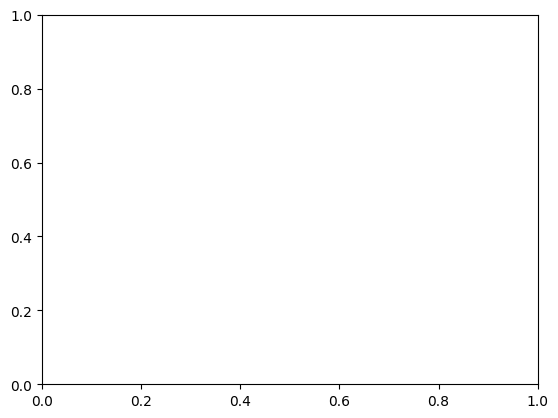

In [11]:
%sqlplot boxplot --table https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2021-01.parquet --column trip_distance

Now, create a query that filters by the 90th percentile.
Note the use of the `--save`, and `--no-execute` functions.
This tells JupySQL to store the query, but skips execution. It will be referenced in the next plotting call.

In [ ]:
%%sql --save short_trips --no-execute
SELECT *
FROM 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2021-01.parquet'
WHERE trip_distance < 6.3

To create a histogram, call `%sqlplot histogram` and pass the name of the table, the column to plot, and the number of bins.
This uses `--with short_trips` so JupySQL uses the query defined previously and therefore only plots a subset of the data.

In [ ]:
%sqlplot histogram --table short_trips --column trip_distance --bins 10 --with short_trips

## Summary
You now have the ability to alternate between SQL and Pandas in a simple and highly performant way! You can plot massive datasets directly through the engine (avoiding both the download of the entire file and loading all of it into Pandas in memory). Dataframes can be read as tables in SQL, and SQL results can be output into Dataframes. Happy analyzing!